In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import pygad

import HydroErr

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 270

# training hyperparameters

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [4]:
embedding = torch.load("data/final_lstm_embedding2.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/final_lstm_decoder2.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [9]:
dtrain_val = dataloader.Forcing_Data(
    "data/data_train_val_CARAVAN_CH.csv",
    record_length=10957,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

# dtrain = dataloader.Forcing_Data(
#     "camels_train.csv",
#     record_length=2922,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

# dval = dataloader.Forcing_Data(
#     "camels_val.csv",
#     record_length=1095,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

dtest = dataloader.Forcing_Data(
    "data/data_test_CARAVAN_CH.csv",
    record_length=4018,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [10]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [11]:
num_generations = 200
num_parents_mating = 10

sol_per_pop = 100
num_genes = LATENT_dim

init_range_low = catchment_embeddings.detach().cpu().min().numpy().tolist()
init_range_high = catchment_embeddings.detach().cpu().max().numpy().tolist()

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.25

x_batch_train_val, y_batch_train_val = dtrain_val.get_val_batch()
x_batch_test, y_batch_test = dtest.get_val_batch()

def evaluate_calibration(selected_catchment=0):
    
    x = x_batch_train_val[:,selected_catchment,:,:]
    y = y_batch_train_val[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    def fitness_func(ga_instance, solution, solution_idx):
        return fn.eval(solution)

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_probability = mutation_probability,
                        stop_criteria=["saturate_10"])

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    # evaluate on test dataset
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    return fn.eval(solution), solution

In [12]:
calibrated_KGES = np.ones(N_CATCHMENTS)
camels_embeddings = np.ones([N_CATCHMENTS, LATENT_dim])

for i in range(N_CATCHMENTS):
    print(f'i={i} starts')
    calibrated_KGES[i], camels_embeddings[i,:]  = evaluate_calibration(i)
    print(f'fit={calibrated_KGES[i]}')

i=0 starts


/Users/yang/opt/anaconda3/envs/pytorch2/lib/python3.11/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [10592 10593 10594 10595 10596 10597 10598 10599 10600 10601 10602 10603
 10604 10605 10606 10607 10608 10609 10610 10611 10612 10613 10614 10615
 10616 10617 10618 10619 10620 10621 10622 10623 10624 10625 10626 10627
 10628 10629 10630 10631 10632 10633 10634 10635 10636 10637 10638 10639
 10640 10641 10642 10643 10644 10645 10646 10647 10648 10649 10650 10651
 10652 10653 10654 10655 10656 10657 10658 10659 10660 10661 10662 10663
 10664 10665 10666 10667 10668 10669 10670 10671 10672 10673 10674 10675
 10676 10677 10678 10679 10680 10681 10682 10683 10684 10685 10686 10687
 10688 10689 10690 10691 10692 10693 10694 10695 10696 10697 10698 10699
 10700 10701 10702 10703 10704 10705 10706 10707 10708 10709 10710 10711
 10712 10713 10714 10715 10716 10717 10718 10719 10720 10721 10722 10723
 10724 10725 10726 10727 10728 10729 10730 10731 10732 10733 10734 10735
 10736 1

fit=0.8913450879031081
i=1 starts
fit=0.905073536458958
i=2 starts
fit=0.8886014414868508
i=3 starts


KeyboardInterrupt: 

In [12]:
np.savetxt("data/ga_KGEs.csv", calibrated_KGES, delimiter=",")
np.savetxt("data/ga_camels_embeddings.csv", camels_embeddings, delimiter=",")

# Result check

In [14]:
calibrated_KGES

array([ 0.91941096,  0.85682169,  0.91637485,  0.88217712,  0.88228154,
        0.88692423,  0.74929147,  0.78510157,  0.86397878,  0.84344607,
        0.76471023,  0.83853438,  0.83633127,  0.78910078,  0.84521933,
        0.81248433,  0.80268453,  0.84948467,  0.74234173,  0.76419514,
        0.76399213,  0.83128169,  0.76749481,  0.7045009 ,  0.78371101,
        0.50837783,  0.77227529,  0.26538183,  0.57192447,  0.6664474 ,
        0.62655947,  0.76148306,  0.71783067,  0.76387803,  0.79151405,
        0.80246345,  0.75337292,  0.78052573,  0.83671804,  0.80459067,
        0.81376294,  0.4992642 ,  0.7323576 ,  0.54922338,  0.80322473,
        0.80011686,  0.86071515,  0.8383424 ,  0.77542572,  0.71476613,
        0.68841337,  0.77964997,  0.51909695,  0.58665682,  0.75903779,
        0.79007346,  0.70983101,  0.58668493,  0.79720012,  0.69344743,
        0.65657411,  0.58694882,  0.69307331,  0.72728967,  0.79509138,
        0.71894977,  0.75483379,  0.68432546,  0.55662402,  0.76

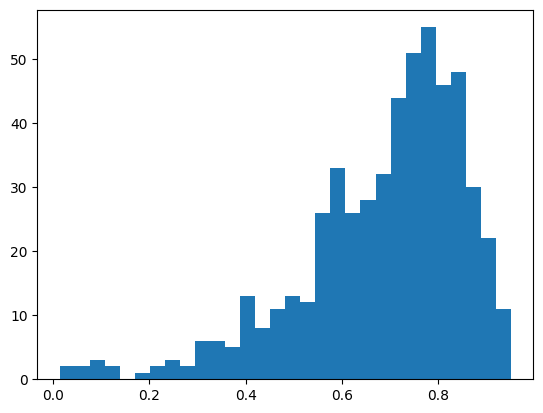

In [8]:
from matplotlib import pyplot as plt

plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [9]:
calibrated_KGES.mean()

0.6511377478097157

In [10]:
np.median(calibrated_KGES)

0.7165318169791439

In [11]:
calibrated_KGES

array([ 0.93864914,  0.81139841,  0.90589687,  0.85936885,  0.88780411,
        0.81618644,  0.78298278,  0.79292717,  0.86002109,  0.88580952,
        0.79435137,  0.83446906,  0.83976704,  0.78880728,  0.83806702,
        0.80829967,  0.82921377,  0.88030742,  0.67890756,  0.73124126,
        0.74209071,  0.84994678,  0.82068269,  0.7262751 ,  0.80621568,
        0.24722365,  0.7512313 ,  0.54888737,  0.62498752,  0.75104824,
        0.71824046,  0.76699311,  0.74987942,  0.70922746,  0.75042409,
        0.7886949 ,  0.70949958,  0.76904734,  0.83663774,  0.75796622,
        0.83484634,  0.4460498 ,  0.72880369,  0.5812842 ,  0.73906844,
        0.79976755,  0.86431163,  0.85086532,  0.75620529,  0.75563354,
        0.68497464,  0.75356664,  0.51069772,  0.57106986,  0.81610585,
        0.7689098 ,  0.73952573,  0.66851425,  0.80474854,  0.70714314,
        0.63099561,  0.59506833,  0.61608368,  0.7378529 ,  0.81673325,
        0.66710605,  0.76420138,  0.70263208,  0.55858068,  0.66